## Zadanie domowe: Projektowanie filtru metodą okien

Zauważone w zadaniu z filtracją artefakty są efektem zastosowania filtru idealnego (wycięcia odpowiednich częstotliwości).
Aby je usunąć, należy filtr idealny w dziedzinie przestrzennej przemnożyć przez dwuwymiarowe okno (stworzone na podstawie jednowymiarowego).

1. Zdefiniuj rozmiar filtra (np. 21).

2. Stwórz okno np. Hamminga (`np.Hmming`) o zadanym rozmiarze.

3. Na podstawie tego okna stwórz okno dwuwymiarowe: $F = f^Tf$.
Można to zrealizować prostą instrukcją:
        hanning2d = np.outer(hanning, hanning)

4. Stwórz wzorcowy filtr idealny tak samo jak w poprzednim ćwiczeniu.
Jego rozmiar musi być taki sam jak zdefiniowany w punkcie pierwszym.

5. Generalna zasada jest taka, że należy obliczyć odwrotną transformatę Fouriera filtru idealnego.
Aby zagwarantować jednak dobrą lokalizację i symetryczność tworzonego filtru wykorzystuje się dodatkowe rotacje i przesunięcia.
```python
        FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
        FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
        FilterFidft = cv2.idft(np.float32(FilterFRot3),
                        flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
        FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)
```
6. Aby otrzymać poprawny filtr należy teraz pomnożyć dwuwymiarowe okno ze stworzonym filtrem idealnym w dziedzinie przestrzennej.

7. Stworzony filtr powinien zostać znowu przeniesiony do dziedziny częstotliwości.
Należy jednak rozszerzyć go tak, aby miał taki sam rozmiar jak filtrowany obraz.
Operację tę wykonaj tak samo jak w poprzednim ćwiczeniu (`cv2.copyMakeBorder`).
Oblicz transformatę Fouriera i wykonaj przesunięcie.
Następnie oblicz wartość bezwzględną (dzięki temu filtr nie będzie wpływał na fazę).
Wynikiem jest poprawiony filtr w dziedzinie częstotliwości.

8. Przeprowadź filtrację obrazu *lena.bmp* za pomocą zaprojektowanego filtra.
Wyświetl filtr, oraz wynik filtracji.
Do wyświetlenia filtru możesz użyć przestrzeń częstotliwości wygenerowaną w poprzednim zadaniu (*FSpaceRowsM* i *FSpaceColsM*).

In [18]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
import math

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/08_Fourier/"

fileNames = ["lena.bmp"]
for fileName in fileNames:
    if not os.path.exists(fileName):
        r = requests.get(url + fileName, allow_redirects=True)
        open(fileName, "wb").write(r.content)

In [19]:
def fourier(image):
    image = image.astype("float32")
    F_img = cv2.dft(image, flags=cv2.DFT_COMPLEX_OUTPUT)
    F_img = np.fft.fftshift(F_img, axes=[0, 1])
    magnitude, phase = cv2.cartToPolar(F_img[:, :, 0], F_img[:, :, 1])
    magnitude_log = np.log10(magnitude.astype("float64") + 1)

    return F_img, magnitude, magnitude_log, phase


def InvertedFourier(F_img):
    F_img = np.fft.ifftshift(F_img, axes=[0, 1])
    f_ishift = cv2.idft(F_img, flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)
    f_ishift = cv2.magnitude(f_ishift[:, :, 0], f_ishift[:, :, 1])
    f_ishift_rounded = np.round(f_ishift.astype("float64")).astype("uint8")
    return f_ishift_rounded

In [20]:
def lowPassFilter(img, radius=0.2):
    F_img, magnitude, magnitude_log, phase = fourier(img)
    FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(img.shape[0]))
    FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, img.shape[1]]))
    FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(img.shape[1]))
    FSpaceColsM = np.outer(np.ones([1, img.shape[0]]), FSpaceCols)

    FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

    FilterF = FreqR <= radius
    figFilter_full = np.repeat(FilterF[:, :, np.newaxis], 2, axis=2)

    result_img = F_img * figFilter_full
    result_img_inv = InvertedFourier(result_img)
    difference = cv2.absdiff(img, result_img_inv)
    return result_img_inv, difference

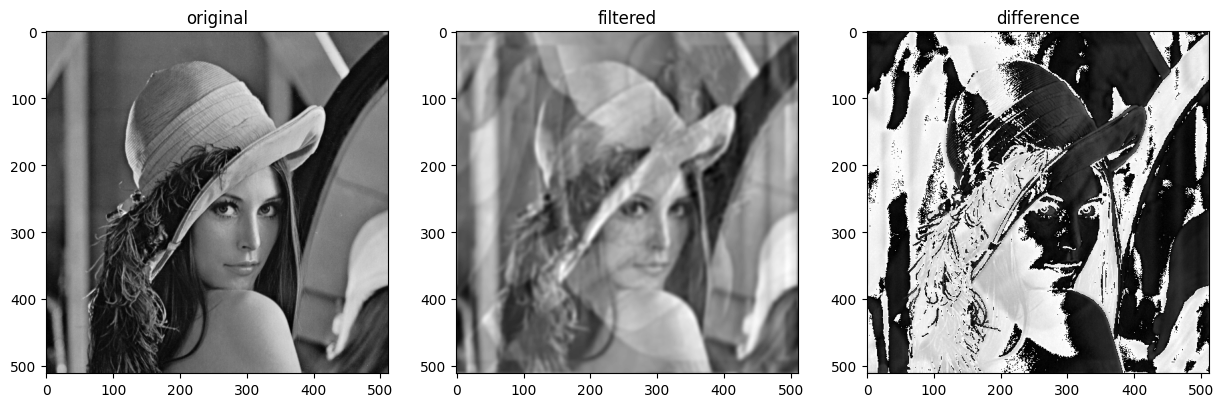

In [21]:
def lowPassFilterWithHamming(img, hanning_size: int = 21, radius: float = 0.2):
    hamming2d = np.outer(np.hamming(hanning_size), np.hamming(hanning_size))

    # Generate 2D frequency space
    FSpaceRows = 2 * np.fft.fftshift(np.fft.fftfreq(hanning_size))
    FSpaceRowsM = np.outer(FSpaceRows, np.ones([1, hanning_size]))
    FSpaceCols = 2 * np.fft.fftshift(np.fft.fftfreq(hanning_size))
    FSpaceColsM = np.outer(np.ones([1, hanning_size]), FSpaceCols)
    FreqR = np.sqrt(np.square(FSpaceRowsM) + np.square(FSpaceColsM))

    # Create a frequency filter
    FilterF = FreqR <= radius
    FilterFRot = np.rot90(np.fft.fftshift(np.rot90(FilterF, 2)), 2)
    FilterFRot3 = np.dstack((FilterFRot, np.zeros(FilterFRot.shape)))
    FilterFidft = cv2.idft(np.float32(FilterFRot3), flags=cv2.DFT_SCALE | cv2.DFT_COMPLEX_OUTPUT)  # type: ignore
    FilterFI = np.rot90(np.fft.fftshift(FilterFidft[:, :, 0]), 2)

    Filter_combined = hamming2d * FilterFI
    Filter_padding = cv2.copyMakeBorder(Filter_combined, 0, img.shape[0] - hanning_size, 0, img.shape[1] - hanning_size, cv2.BORDER_CONSTANT, value=0)  # type: ignore

    # Perform 2D Fourier Transform
    F_fcn_filtr = cv2.dft(Filter_padding, flags=cv2.DFT_COMPLEX_OUTPUT)
    F_fcn_filtr = np.fft.fftshift(F_fcn_filtr, [0, 1])
    # Calculate the magnitude of the Fourier Transform of the filter
    F_fcn_filtr_abs = np.abs(F_fcn_filtr)

    # Apply the filter to the Fourier Transform of the input image
    F_lena_filtr = fourier(img)[0] * F_fcn_filtr_abs
    # Invert the Fourier Transform to get the filtered image
    lena_ifft_2 = InvertedFourier(F_lena_filtr)

    diff_2 = np.abs(img - lena_ifft_2)

    fig, axs = plt.subplots(1, 3)
    fig.set_figheight(10)
    fig.set_figwidth(15)
    axs[0].imshow(img, "gray")
    axs[0].set_title("original")
    axs[1].imshow(lena_ifft_2, "gray")
    axs[1].set_title("filtered")
    axs[2].imshow(diff_2, "gray")
    axs[2].set_title("difference")
    plt.show()


    # FSpaceRows_512 = 2 * np.fft.fftshift(np.fft.fftfreq(img.shape[0]))
    # FSpaceRowsM_512 = np.outer(FSpaceRows_512, np.ones([1, img.shape[1]]))
    # FSpaceCols_512 = 2 * np.fft.fftshift(np.fft.fftfreq(img.shape[1]))
    # FSpaceColsM_512 = np.outer(np.ones([1, img.shape[0]]), FSpaceCols_512)
    # # Plot
    # figFilter = plt.figure()
    # axsFilter = figFilter.add_subplot(projection="3d")
    # axsFilter.plot_surface(FSpaceRowsM_512, FSpaceColsM_512, F_fcn_filtr_abs[:, :, 0], rstride=1, cstride=1, cmap=plt.get_cmap("gray"), linewidth=0)  # type: ignore


lowPassFilterWithHamming(cv2.imread("lena.bmp", cv2.IMREAD_GRAYSCALE), 21, 0.2)